In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Defining a Dataset Satisfying the Simpson's Paradox

class Fraction:
    def __init__(self, numerator, denominator):
        if denominator == 0:
            raise ValueError("Denominator cannot be zero.")
        self.numerator = numerator
        self.denominator = denominator

    def __str__(self):
        return f"{self.numerator}/{self.denominator}"

a, b, c, d = 30, 40, 70, 330

m = 10
n = 1


data = {"mild": [], "severe": [], "total": []}

for i in range(m+1):
    x = a + i*(10**n)
    y = b + i*(10**n)
    z = c + 3*i*(10**n)
    w = d + 14*i*(10**n)
    mild = Fraction(x, y)
    severe = Fraction(z, w)
    total = Fraction(x + z, y + w)
    data["mild"].append(mild)
    data["severe"].append(severe)
    data["total"].append(total)


df_with_t_values = pd.DataFrame(data, index=[f"T = {i}" for i in range(m+1)])
df_with_t_values


,mild,severe,total
T = 0,30/40,70/330,100/370
T = 1,40/50,100/470,140/520
T = 2,50/60,130/610,180/670
T = 3,60/70,160/750,220/820
T = 4,70/80,190/890,260/970
T = 5,80/90,220/1030,300/1120
T = 6,90/100,250/1170,340/1270
T = 7,100/110,280/1310,380/1420
T = 8,110/120,310/1450,420/1570
T = 9,120/130,340/1590,460/1720


In the above table, for instance, the value corresponding to $T=t$ and $mild$ condition, is the rate of the cured patients with the mild condition, cured by $T=t$.

In [ ]:
# Recreate the above dataset with exact values instead of fractions

Data = {"Mild": [], "Severe": [],  "pr_mild": [], "pr_severe": [], "Total": []}

for i in range(m+1):
    x = a + i*n
    y = b + i*n
    z = c + 3*i*n
    w = d + 14*i*n
    mild = x/y
    severe = z/w
    total = (x + z)/(y + w)
    pr_mild = y/(y+w)
    pr_severe = w/(y+w)
    Data["Mild"].append(mild)
    Data["Severe"].append(severe)
    Data["Total"].append(total)
    Data["pr_mild"].append(pr_mild)
    Data["pr_severe"].append(pr_severe)

Data = pd.DataFrame(Data, index=[f"T = {i}" for i in range(m+1)])
Data

,Mild,Severe,pr_mild,pr_severe,Total
T = 0,0.750000,0.212121,0.108108,0.891892,0.270270
T = 1,0.756098,0.212209,0.106494,0.893506,0.270130
T = 2,0.761905,0.212291,0.105000,0.895000,0.270000
T = 3,0.767442,0.212366,0.103614,0.896386,0.269880
T = 4,0.772727,0.212435,0.102326,0.897674,0.269767
T = 5,0.777778,0.212500,0.101124,0.898876,0.269663
T = 6,0.782609,0.212560,0.100000,0.900000,0.269565
T = 7,0.787234,0.212617,0.098947,0.901053,0.269474
T = 8,0.791667,0.212670,0.097959,0.902041,0.269388
T = 9,0.795918,0.212719,0.097030,0.902970,0.269307


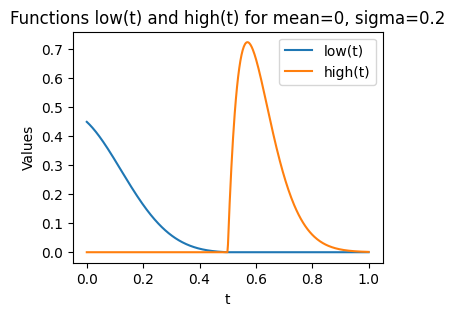

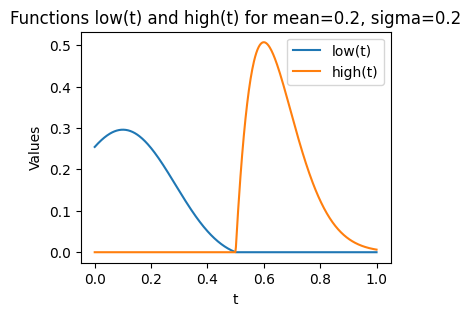

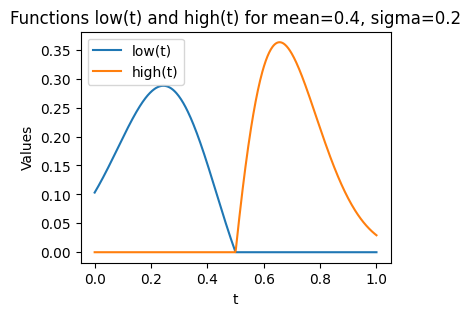

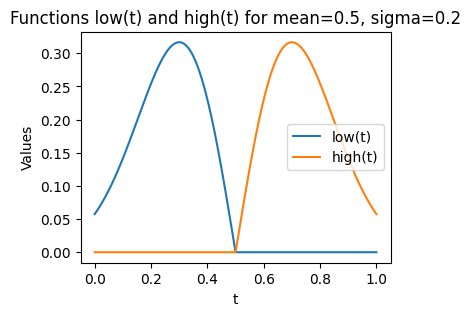

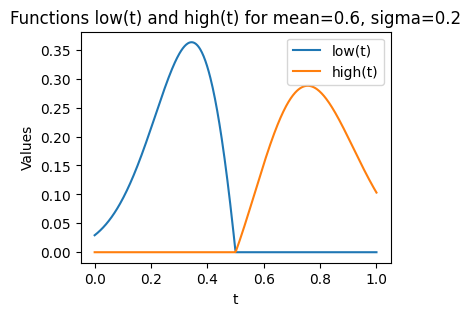

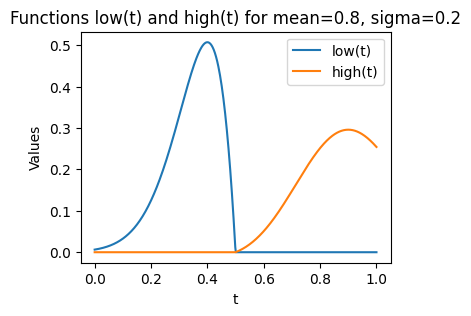

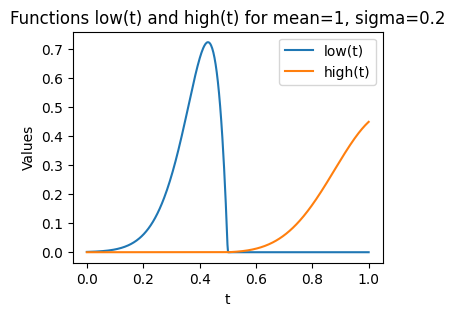

,mean,sigma,causal_effect
0,0.0,0.2,0.002902
1,0.2,0.2,0.002693
2,0.4,0.2,0.002485
3,0.5,0.2,0.002422
4,0.6,0.2,0.002400
5,0.8,0.2,0.002451
6,1.0,0.2,0.002538


In [ ]:
# Calculating the FATE when T follows a normal-like distribution

Data_np = Data.to_numpy()
def fuzzy_causal_effect(mean, sigma, plot=True):
  def Prob_T(t):
    return (1/(np.sqrt(2*np.pi)*sigma**2))*np.exp(-0.5*((t-mean)**2)/(sigma**2))

  norm_T = 0
  for i in range(m+1):
    point = i/m
    norm_T += Prob_T(point)

  def prob_T(t):
    return Prob_T(t)/norm_T

  def Low(t):
    if 0<= t <= 0.5:
      return -0.2*(t-0.5)
    else:
      return 0

  def High(t):
    if 0.5<= t <= 1:
      return 0.2*(t-0.5)
    else:
      return 0

  norm_low = 0
  norm_high = 0
  for i in range(m+1):
    point = i/m
    norm_low += prob_T(point) * Low(point)
    norm_high += prob_T(point) * High(point)

  def low(t):
    if 0<= t <= 0.5:
      return (Low(t)/norm_low) * prob_T(t)
    else:
      return 0

  def high(t):
    if 0.5<= t <= 1:
      return (High(t)/norm_high) * prob_T(t)
    else:
      return 0

  if plot:
        t_values = np.linspace(0, 1, 500)
        low_values = [low(t) for t in t_values]
        high_values = [high(t) for t in t_values]

        plt.figure(figsize=(4, 3))
        plt.plot(t_values, low_values, label='low(t)')
        plt.plot(t_values, high_values, label='high(t)')
        plt.title(f'Functions low(t) and high(t) for mean={mean}, sigma={sigma}')
        plt.xlabel('t')
        plt.ylabel('Values')
        plt.legend()
        plt.show()

  expected_low = 0
  expected_high = 0
  for c in range(2):
    for i in range(m+1):
      point = 0.1 * i
      expected_low += low(point) * Data_np[i,c]
      expected_high += high(point) * Data_np[i,c]
    expected_low *= Data_np[i,c+2]
    expected_high *= Data_np[i,c+2]
  return expected_high - expected_low

means = [0, 0.2,  0.4, 0.5, 0.6,  0.8, 1]
sigmas = [0.2]

results = []

for mean in means:
    for sigma in sigmas:
        effect = fuzzy_causal_effect(mean, sigma)
        results.append({'mean': mean, 'sigma': sigma, 'causal_effect': effect})

df_results = pd.DataFrame(results)

df_results